In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline

You can see this notebook and get CSV File in: https://www.kaggle.com/leopoldozanellato/playstore-app-rating-random-forest-cross-val

In [3]:
train = pd.read_csv("googleplaystore.csv")

In [4]:
train.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


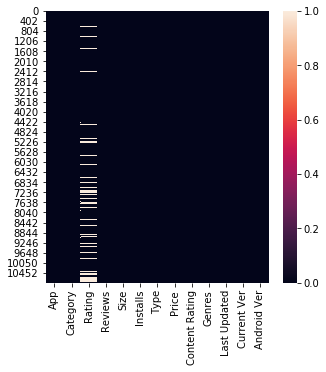

In [6]:
plt.figure(figsize=(5,5))
sns.heatmap(train.isnull())

In [7]:
train.dropna(axis=0, inplace=True)

In [8]:
# função para arrumar a versão
def get_android_ver(x):
    if x == "Varies with device":
        return 4           # 4 it's median
    else:
        palavra =  re.findall(r'[^a-zA-Z]',x)
        palavra = "".join(palavra)
        return float(palavra[:3])

In [9]:
train['Android Ver'] = train['Android Ver'].apply(lambda x: get_android_ver(x))

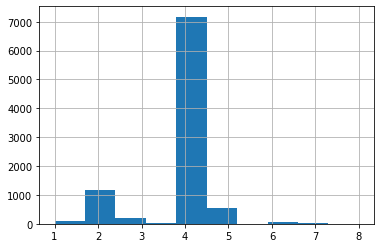

In [10]:
train['Android Ver'].hist()

In [11]:
print(train['Android Ver'].median())

4.0


In [12]:
# funções para obter o tamanho do app
def get_string(x):
    if (len(x)) >5:
        return x
    elif (len(x)) <=5:
        string = re.findall(r'[a-zA-Z]',x)
        return "".join(string)
    
def get_number(x):
    number =  re.findall(r'[^a-zA-Z]',x)
    if len(x) > 5:
        return 0   # analisar essa parte
    else:
        return float("".join(number))

In [13]:
train['Strings'] = train['Size'].apply(lambda x: get_string(x))
train['Numbers'] = train['Size'].apply(lambda x: float(get_number(x)))

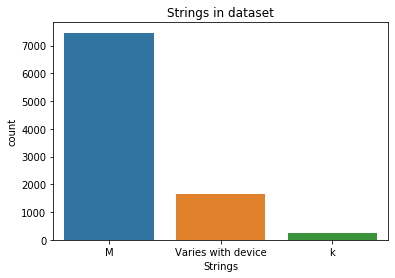

In [14]:
plt.title('Strings in dataset')
sns.countplot(train['Strings'])

In [15]:
# train['Numbers'].median()

In [16]:
# transformar tudo de kb para mb
def get_size(cols):
    letra = cols[0]
    numero = cols[1]
    if letra == 'k':
        tamanho = numero /1024
        return tamanho
    elif letra == 'M':
        tamanho = numero /1 
        return tamanho
    else:
        return "none"

In [17]:
train['Size'] = train[['Strings','Numbers']].apply(get_size, axis=1)

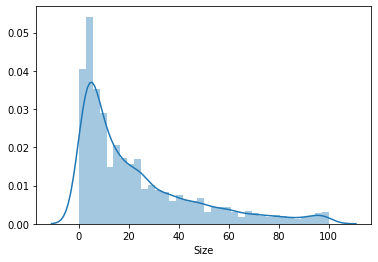

In [18]:
mediansize = train[train['Size']!='none']
sns.distplot(mediansize['Size'])

In [19]:
def get_size2(x):
    if x == "none":
        return 22.97
    else:
        return x

In [20]:
train['Size'] = train['Size'].apply(lambda x: get_size2(x))

In [21]:
# arrumar a coluna installs
def get_installs(x):
    x = x.replace(",","")
    x = x.replace("+","")
    return int(x)

In [22]:
train['Installs'] = train['Installs'].apply(lambda x: int(get_installs(x)))

In [23]:
train['Last Updated'] = train['Last Updated'].apply(lambda x: "".join(l for l in x if l not in string.punctuation))
train['Last Updated'] = train['Last Updated'].apply(lambda x: x.split())

In [24]:
train['Last Updated'].head()

0     [January, 7, 2018]
1    [January, 15, 2018]
2      [August, 1, 2018]
3        [June, 8, 2018]
4       [June, 20, 2018]
Name: Last Updated, dtype: object

In [25]:
train['Ano'] = train['Last Updated'][0][2]
train['Mês'] = train['Last Updated'][0][0]

In [26]:
months = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
          'August':8, 'September':9, 'October':10, 'November':11,'December':12 }

In [27]:
train['Mês'] = train['Mês'].apply(lambda x: months.get(x))
train['Ano'] =train['Ano'].astype(int)
train['Mês'] =train['Mês'].astype(int)


In [28]:
train['Reviews'] = train['Reviews'].astype(int)

In [29]:
def get_price(x):
    numero = re.findall('[^$]', x)
    return "".join(numero)

In [30]:
train['Price'] = train['Price'].apply(lambda x: get_price(x))

In [31]:
train['Price'] = train['Price'].astype(float)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B85C0E2608>,
      dtype=object)

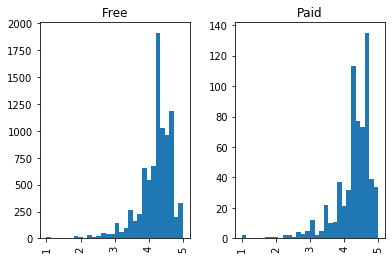

In [32]:
train['Rating'].hist(bins=30, by=train['Type'])

In [33]:
train[['Type','Rating']].groupby('Type').mean()

,Rating
Type,
Free,4.186288
Paid,4.266822


In [34]:
category = train[['Category','Rating']].groupby('Category').mean().sort_values(ascending=False,by='Rating')

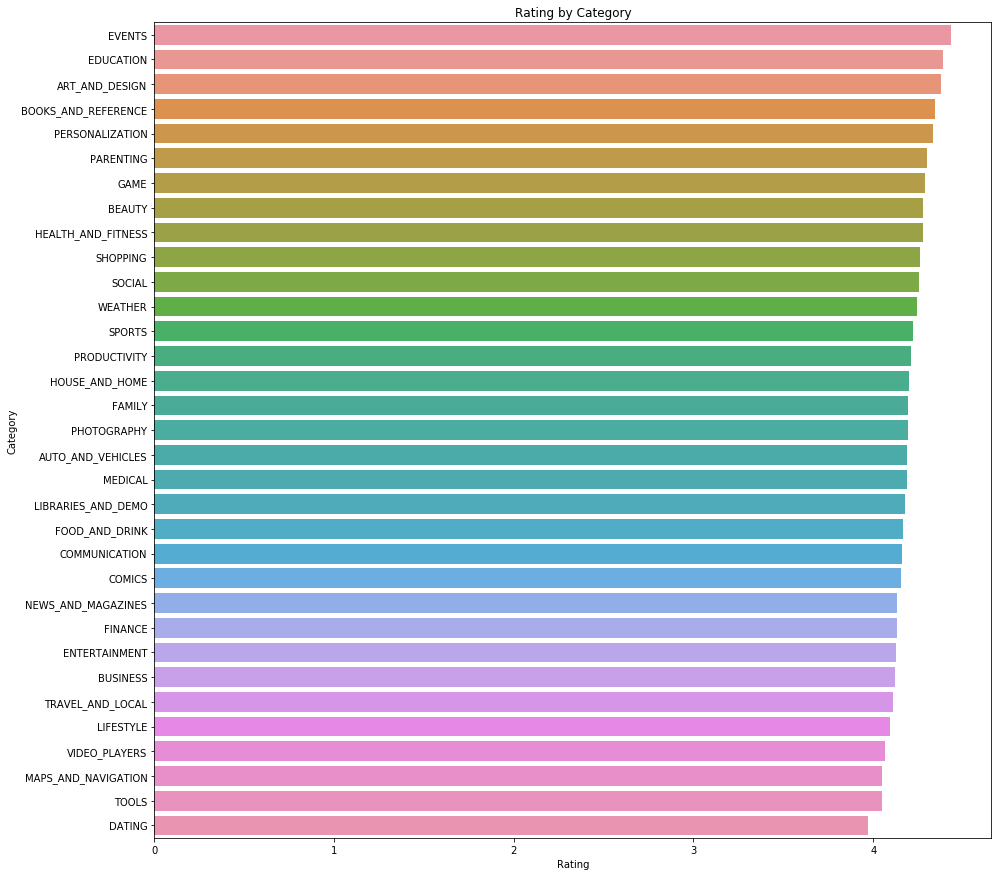

In [35]:
plt.figure(figsize=(15,15))
plt.title("Rating by Category")
sns.barplot(x=category['Rating'], y=category.index)

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   int32  
 4   Size            9360 non-null   float64
 5   Installs        9360 non-null   int64  
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   float64
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
 10  Last Updated    9360 non-null   object 
 11  Current Ver     9360 non-null   object 
 12  Android Ver     9360 non-null   float64
 13  Strings         9360 non-null   object 
 14  Numbers         9360 non-null   float64
 15  Ano             9360 non-null   int32  
 16  Mês             9360 non-null   int32  
dtypes: float64(5), int32(3), int64(1

In [37]:
train.drop(['Strings','Numbers','Current Ver','Last Updated'],axis=1, inplace=True)

In [38]:
objectcol = list(train.select_dtypes(include='object').columns)
objectcol

['App', 'Category', 'Type', 'Content Rating', 'Genres']

In [39]:
badcol = []
goodcol = []
for col in objectcol:
    nunique = train[col].nunique()
    print(f'{col}: {nunique}')
    if nunique > 10:
        badcol.append(col)
    else:
        goodcol.append(col)

App: 8190
Category: 33
Type: 2
Content Rating: 6
Genres: 115


In [40]:
print(badcol)
print(goodcol)

['App', 'Category', 'Genres']
['Type', 'Content Rating']


In [41]:
typedummie = pd.get_dummies(train['Type'])

In [42]:
train = pd.concat([train,typedummie],axis=1)

In [43]:
ratingdummie = pd.get_dummies(train['Content Rating'])

In [44]:
train = pd.concat([train,ratingdummie],axis=1)

In [45]:
train.drop(goodcol, axis=1, inplace=True)

In [46]:
train.drop(['App','Genres','Category'], axis=1, inplace=True)

In [47]:
train.head()

,Rating,Reviews,Size,Installs,Price,Android Ver,Ano,Mês,Free,Paid,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated
0,4.1,159,19.0,10000,0.0,4.0,2018,1,1,0,0,1,0,0,0,0
1,3.9,967,14.0,500000,0.0,4.0,2018,1,1,0,0,1,0,0,0,0
2,4.7,87510,8.7,5000000,0.0,4.0,2018,1,1,0,0,1,0,0,0,0
3,4.5,215644,25.0,50000000,0.0,4.2,2018,1,1,0,0,0,0,0,1,0
4,4.3,967,2.8,100000,0.0,4.4,2018,1,1,0,0,1,0,0,0,0


In [48]:
train.shape

(9360, 16)

In [49]:
y = train['Rating']
x = train.drop('Rating',axis=1)

In [50]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3, random_state=42)

In [51]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
xtrain=sc_X.fit_transform(xtrain)
xtest=sc_X.transform(xtest)

In [52]:
from sklearn.tree import DecisionTreeRegressor

In [53]:
def score_dataset(xtrain,xtest,ytrain,ytest,n_estimators):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(xtrain,ytrain)
    pred = model.predict(xtest)
    return mean_absolute_error(ytest,pred)

In [54]:
index = []
score = []
for n in [100,200,300,400,500]:
    index.append(n)
    score.append(score_dataset(xtrain,xtest,ytrain,ytest,n,))

Text(0, 0.5, 'mae')

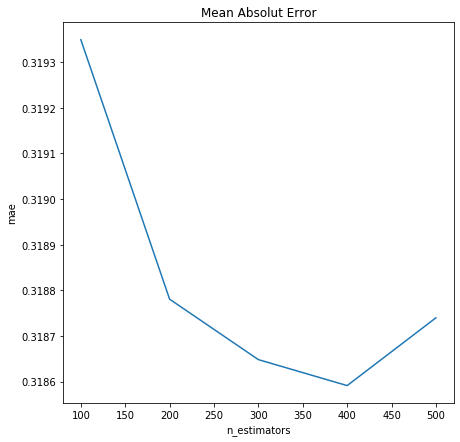

In [55]:
plt.figure(figsize=(7,7))
plt.title('Mean Absolut Error')
sns.lineplot(x=index,y=score)
plt.xlabel('n_estimators')
plt.ylabel('mae')

In [56]:
model = RandomForestRegressor(n_estimators=400, random_state=42)
model.fit(xtrain,ytrain)
predict = model.predict(xtest)
mean_absolute_error(ytest,predict)

0.31859123380477594

In [57]:
print(f' Mean Absolut Error: {mean_absolute_error(ytest,predict)}')
print(f' Mean Squared Error: {mean_squared_error(ytest, predict)}')
print(f' SQRT  {np.sqrt(mean_squared_error(ytest, predict))}')

 Mean Absolut Error: 0.31859123380477594
 Mean Squared Error: 0.23555836441091868
 SQRT  0.485343552971417


In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [59]:
my_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                              ('model', RandomForestRegressor(n_estimators=400,
                                                              random_state=42))
                             ])

In [60]:
scores = -1 * cross_val_score(my_pipeline, x, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [0.24826951 0.23577585 0.34500509 0.42571319 0.3957861 ]


In [61]:
index = np.arange(1,6)

Text(0, 0.5, 'mae')

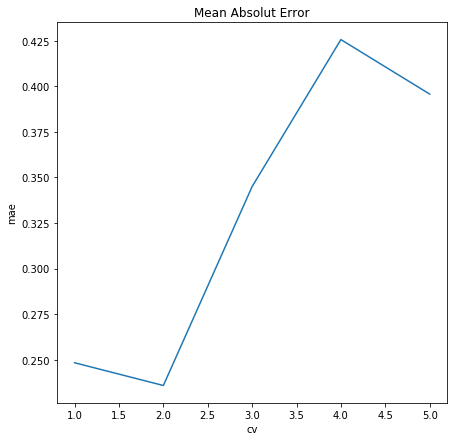

In [62]:
plt.figure(figsize=(7,7))
plt.title('Mean Absolut Error')
sns.lineplot(x=index,y=scores)
plt.xlabel('cv')
plt.ylabel('mae')

In [63]:
print(scores.mean())

0.33010994823463596
